In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import gc
import glob
import json
import random
from functools import lru_cache
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import shap
import torch
import xarray as xr
from neuralhydrology.evaluation import get_tester
from neuralhydrology.nh_run import eval_run, start_run
from neuralhydrology.utils.config import Config
from scripts.file_manipulator import test_rewriter, train_rewriter
from shap import force_plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from tqdm.notebook import tqdm

shap.initjs()
gpd.options.io_engine = "pyogrio"


@lru_cache
def read_ws(gpkg_path):
    ws_file = gpd.read_file(filename=gpkg_path)
    ws_file = ws_file.set_index("gauge_id")

    return ws_file


# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Single gauge quality

In [5]:
meteo_inputs = ["prcp_mswep", "t_max_e5l", "t_min_e5l"]

# q_mm_day or lvl_sm
hydro_target = "q_mm_day"
static_parameters = [
    "for_pc_sse",
    "crp_pc_sse",
    "inu_pc_ult",
    "ire_pc_sse",
    "lka_pc_use",
    "prm_pc_sse",
    "pst_pc_sse",
    "cly_pc_sav",
    "slt_pc_sav",
    "snd_pc_sav",
    "kar_pc_sse",
    "urb_pc_sse",
    "gwt_cm_sav",
    "lkv_mc_usu",
    "rev_mc_usu",
    "ws_area",
    "ele_mt_sav",
]
nc_variable = "nc_all_q"

ws_file = read_ws("../geo_data/geometry/russia_ws.gpkg")

# time series directory
ts_dir = Path("../geo_data/time_series")

In [4]:
cfg_path = Path("./model_runs/ealstm_q_mm_day_mswep_no_static_0205_144958/config.yml")

train_rewriter(
    era_paths=glob.glob(f"../geo_data/ws_related_meteo/{nc_variable}/*.nc"),
    ts_dir=ts_dir,
    hydro_target=hydro_target,
    area_index=ws_file.index,
    predictors=[*meteo_inputs],
    possible_nans=1,
)
cfg = Config(cfg_path)
eval_run(run_dir=cfg.run_dir, period="test", epoch=38)

# Evaluation: 100%|██████████| 1111/1111 [03:29<00:00,  5.31it/s]


In [ ]:
configs = list(
    Path("./model_runs/single_gauge/").glob("*/cudalstm_q_mm_day*/config.yml")
)

for cfg_path in tqdm(configs):
    gauge_id = cfg_path.parents[1].stem
    train_rewriter(
        era_paths=glob.glob(f"../geo_data/ws_related_meteo/{nc_variable}/*.nc"),
        ts_dir=ts_dir,
        hydro_target=hydro_target,
        area_index=[gauge_id],
        predictors=[*meteo_inputs],
        possible_nans=1,
    )
    cfg = Config(cfg_path)
    eval_run(run_dir=cfg.run_dir, period="test", epoch=30)

In [8]:
import pickle

# Open the .p file
with open(
    "./model_runs/ealstm_q_mm_day_mswep_no_static_0205_144958/test/model_epoch038/test_results.p",
    "rb",
) as f:
    # Load the data from the .p file
    data = pickle.load(f)

# Now you can work with the data
data["10006"]['1D']['xr']

<xarray.Dataset> Size: 12kB
Dimensions:       (date: 731, time_step: 1)
Coordinates:
  * date          (date) datetime64[ns] 6kB 2019-01-01 2019-01-02 ... 2020-12-31
  * time_step     (time_step) int64 8B 0
Data variables:
    q_mm_day_obs  (date, time_step) float32 3kB 0.2163 0.2148 ... 0.2308 0.2288
    q_mm_day_sim  (date, time_step) float32 3kB 0.1639 0.153 ... 0.3051 nan

In [72]:
with open(f"{logs[0]}", "r") as f:
    lines = f.readlines()
full_lines = [line for line in lines if ("NSE" in line) & ("Epoch" in line)]

epoch_nse = {
    int(line.split(" Epoch ")[1].split(" ")[0]): float(
        line.split(" NSE: ")[1].split(",")[0]
    )
    for line in full_lines
}

epoch_nse[max(epoch_nse, key=epoch_nse.get)]

0.69995

0.69995

In [78]:
from pathlib import Path

configs = list(Path("./model_runs/").glob("cudalstm_q_mm_day*mswep*/config.yml"))
configs_names = [str(i).split("/")[1].split("_no")[0] for i in configs]
logs = list(Path("./model_runs/").glob("cudalstm_q_mm_day*mswep*/output.log"))
test_metrics = list(
    pd.read_csv(metric_res)["NSE"].median()
    for metric_res in Path("./model_runs/").glob(
        "cudalstm_q_mm_day*mswep*/test/*/test_metrics.csv"
    )
)


def best_epoch_finder(log_file: Path) -> int:
    with open(f"{log_file}", "r") as f:
        lines = f.readlines()
    full_lines = [line for line in lines if ("NSE" in line) & ("Epoch" in line)]

    epoch_nse = {
        int(line.split(" Epoch ")[1].split(" ")[0]): float(
            line.split(" NSE: ")[1].split(",")[0]
        )
        for line in full_lines
    }

    max_epoch = max(epoch_nse, key=epoch_nse.get)
    max_nse = epoch_nse[max_epoch]

    return max_epoch, max_nse


metric_hyperparam_df = pd.DataFrame()

for cfg_name, log, cfg, nse_med in zip(configs_names, logs, configs, test_metrics):
    metric_hyperparam_df.loc[cfg_name, "epoch"] = best_epoch_finder(log)[0]
    metric_hyperparam_df.loc[cfg_name, "h_s"] = Config(cfg).hidden_size
    metric_hyperparam_df.loc[cfg_name, "seq_len"] = Config(cfg).seq_length
    metric_hyperparam_df.loc[cfg_name, "NSE test"] = nse_med
    metric_hyperparam_df.loc[cfg_name, "NSE val"] = best_epoch_finder(log)[1]

metric_hyperparam_df["perfomance loss"] = (
    metric_hyperparam_df["NSE val"] - metric_hyperparam_df["NSE test"]
)/metric_hyperparam_df['NSE val'] * 100

In [111]:
metric_hyperparam_df.sort_values(by="NSE test", ascending=False).to_csv('../conclusions/tables/Hyperparameter_Rankings.csv')

### Single gauge quality

In [86]:
pd.read_csv(
    "/workspaces/my_dissertation/neural_forecast/model_runs/single_gauge/1151/cudalstm_q_mm_day_1151_mswep_mo_static_2604_212424/test/model_epoch030/test_metrics.csv"
)['NSE']

0    0.371853
Name: NSE, dtype: float64

In [107]:
gauges = list(i.stem for i in Path("./model_runs/single_gauge/").glob("*"))
metrics = list(Path("./model_runs/single_gauge/").glob("*/*/test/*/*.csv"))
test_results = list()

single_gauge_model = pd.DataFrame()

for gauge_id, metric_file in zip(gauges, metrics):
    single_gauge_model.loc[gauge_id, "NSE"] = pd.read_csv(f"{metric_file}").loc[0, "NSE"]


In [110]:
single_gauge_model['NSE'].to_csv("../conclusions/tables/LSTM_single_gauge.csv")

In [115]:
metric_hyperparam_df.sort_values("NSE test", ascending=False)

,epoch,h_s,seq_len,NSE test,NSE val,perfomance loss
cudalstm_q_mm_day_256_270_mswep_static_1505_112923,30.0,256.0,270.0,0.653135,0.71950,9.223812
cudalstm_q_mm_day_128_270_mswep_static_1605_083633,22.0,128.0,270.0,0.645199,0.70293,8.212862
cudalstm_q_mm_day_mswep,24.0,256.0,365.0,0.641360,0.70787,9.395749
cudalstm_q_mm_day_128_mswep_static_1405_112752,24.0,128.0,365.0,0.630440,0.69914,9.826384
cudalstm_q_mm_day_256_180_mswep_static_1505_143924,23.0,256.0,180.0,0.627072,0.69995,10.411847
cudalstm_q_mm_day_128_180_mswep_static_1605_105712,15.0,128.0,180.0,0.614615,0.70412,12.711646
cudalstm_q_mm_day_256_90_mswep_static_1505_174154,25.0,256.0,90.0,0.611303,0.67560,9.516955
cudalstm_q_mm_day_64_270_mswep_static_1605_232505,13.0,64.0,270.0,0.607850,0.68954,11.847087
cudalstm_q_mm_day_64_mswep_static_1405_142451,29.0,64.0,365.0,0.599421,0.68092,11.968902
cudalstm_q_mm_day_64_180_mswep_static_1705_090029,20.0,64.0,180.0,0.593709,0.68837,13.751515


Feature h_s: 0.2321761696703919
Feature seq_len: 0.767823830329608
Feature seq_len: 1.447733419482961
Feature h_s: 0.4371150400005053


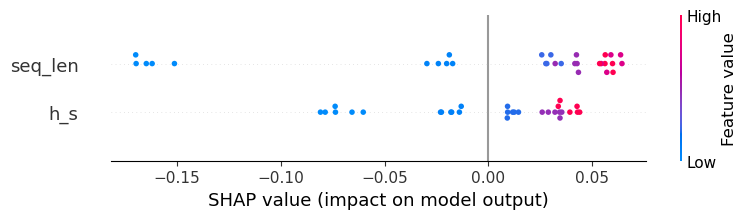

In [41]:
x = metric_hyperparam_df.drop(["epoch", "NSE"], axis=1)
y = metric_hyperparam_df["NSE"]
# Train a surrogate model
model = RandomForestRegressor()
model.fit(x, y)

# Feature importance from the model
importances = model.feature_importances_
for feature, importance in zip(x.columns, importances):
    print(f"Feature {feature}: {importance}")

# Permutation importance
result = permutation_importance(model, x, y, n_repeats=100, random_state=0)
for i in result.importances_mean.argsort()[::-1]:
    print(f"Feature {x.columns[i]}: {result.importances_mean[i]}")

# SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)

# Visualize SHAP values
shap.summary_plot(shap_values, x)

In [66]:


shap.force_plot(explainer.expected_value, shap_values[:], x[:])

In [43]:
shap_values

array([[ 0.04297004,  0.04342279],
       [-0.02257325,  0.05707631],
       [ 0.03455086, -0.02957762],
       [-0.01304813,  0.03511332],
       [-0.07856798,  0.05440708],
       [ 0.03541102,  0.06373546],
       [-0.08085003,  0.03220968],
       [ 0.03435535,  0.04276444],
       [-0.07378146,  0.02770549],
       [ 0.02596131, -0.16964182],
       [ 0.04401858,  0.06438669],
       [-0.01392672, -0.01877376],
       [ 0.03370674, -0.16985271],
       [ 0.03453909,  0.05983674],
       [ 0.0117148 ,  0.03013178],
       [ 0.04274872,  0.06009005],
       [-0.07362076,  0.05632751],
       [-0.01804027,  0.04169393],
       [-0.06024115, -0.15119365],
       [ 0.03210769, -0.02406447],
       [ 0.01453097, -0.02006054],
       [ 0.03929909,  0.02817909],
       [ 0.0289075 ,  0.02574383],
       [-0.06565193, -0.01717347],
       [-0.01765334, -0.16193135],
       [-0.02300477,  0.05361799],
       [ 0.00931701,  0.05619532],
       [ 0.00927684, -0.16474563],
       [ 0.01247451,

In [23]:
description_dict

{'cudalstm_q_mm_day_256_180_mswep_static_1505_143924': (23, 256, 180),
 'cudalstm_q_mm_day_32_270_mswep_static_1705_174210': (22, 32, 270),
 'cudalstm_q_mm_day_256_30_mswep_static_1505_194823': (11, 256, 30),
 'cudalstm_q_mm_day_32_90_mswep_static_1705_220829': (25, 32, 90),
 'cudalstm_q_mm_day_16_270_mswep_static_1805_012327': (20, 16, 270),
 'cudalstm_q_mm_day_128_270_mswep_static_1605_083633': (22, 128, 270),
 'cudalstm_q_mm_day_16_180_mswep_static_1805_033840': (29, 16, 180),
 'cudalstm_q_mm_day_128_180_mswep_static_1605_105712': (15, 128, 180),
 'cudalstm_q_mm_day_16_90_mswep_static_2005_093959': (27, 16, 90),
 'cudalstm_q_mm_day_128_10_mswep_static_1605_135215': (29, 128, 10),
 'cudalstm_q_mm_day_256_270_mswep_static_1505_112923': (30, 256, 270),
 'cudalstm_q_mm_day_32_30_mswep_static_1705_232606': (29, 32, 30),
 'cudalstm_q_mm_day_256_10_mswep_static_1605_075013': (19, 256, 10),
 'cudalstm_q_mm_day_128_mswep_static_1405_112752': (24, 128, 365),
 'cudalstm_q_mm_day_64_90_mswep_st

In [17]:
best_epochs

{23: {'hidden_size': 32, 'seq_length': 10},
 22: {'hidden_size': 64, 'seq_length': 90},
 11: {'hidden_size': 256, 'seq_length': 30},
 25: {'hidden_size': 256, 'seq_length': 90},
 20: {'hidden_size': 64, 'seq_length': 180},
 29: {'hidden_size': 64, 'seq_length': 365},
 15: {'hidden_size': 128, 'seq_length': 180},
 27: {'hidden_size': 16, 'seq_length': 30},
 30: {'hidden_size': 32, 'seq_length': 180},
 19: {'hidden_size': 256, 'seq_length': 10},
 24: {'hidden_size': 64, 'seq_length': 10},
 28: {'hidden_size': 16, 'seq_length': 365},
 26: {'hidden_size': 64, 'seq_length': 30},
 21: {'hidden_size': 32, 'seq_length': 365},
 10: {'hidden_size': 128, 'seq_length': 90},
 14: {'hidden_size': 256, 'seq_length': 365},
 13: {'hidden_size': 64, 'seq_length': 270}}

In [14]:
logs

[PosixPath('model_runs/cudalstm_q_mm_day_256_180_mswep_static_1505_143924/output.log'),
 PosixPath('model_runs/cudalstm_q_mm_day_32_270_mswep_static_1705_174210/output.log'),
 PosixPath('model_runs/cudalstm_q_mm_day_256_30_mswep_static_1505_194823/output.log'),
 PosixPath('model_runs/cudalstm_q_mm_day_32_90_mswep_static_1705_220829/output.log'),
 PosixPath('model_runs/cudalstm_q_mm_day_16_270_mswep_static_1805_012327/output.log'),
 PosixPath('model_runs/cudalstm_q_mm_day_128_270_mswep_static_1605_083633/output.log'),
 PosixPath('model_runs/cudalstm_q_mm_day_16_180_mswep_static_1805_033840/output.log'),
 PosixPath('model_runs/cudalstm_q_mm_day_128_180_mswep_static_1605_105712/output.log'),
 PosixPath('model_runs/cudalstm_q_mm_day_16_90_mswep_static_2005_093959/output.log'),
 PosixPath('model_runs/cudalstm_q_mm_day_128_10_mswep_static_1605_135215/output.log'),
 PosixPath('model_runs/cudalstm_q_mm_day_256_270_mswep_static_1505_112923/output.log'),
 PosixPath('model_runs/cudalstm_q_mm_day_

In [43]:
meteo_inputs = [
    # ["prcp_gpcp", "t_max_e5l", "t_min_e5l"],
    ["prcp_mswep", "t_max_e5l", "t_min_e5l"],
    # ["prcp_e5", "t_max_e5", "t_min_e5"],
    # ["prcp_e5l", "t_max_e5l", "t_min_e5l"],
    # ["prcp_mswep", "t_max_e5", "t_min_e5"],
] * len(best_epochs)

meteo_inputs

[['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_mswep', 't_max_e5l', 't_min_e5l'],
 ['prcp_msw

29

In [24]:
full_lines

['2024-05-16 13:54:52,874: Epoch 1 average validation loss: 0.00009 -- Median validation metrics: avg_loss: 0.00009, NSE: 0.29416, RMSE: 0.67068, KGE: 0.28453\n',
 '2024-05-16 13:56:30,353: Epoch 2 average validation loss: 0.00009 -- Median validation metrics: avg_loss: 0.00009, NSE: 0.32390, RMSE: 0.66489, KGE: 0.38840\n',
 '2024-05-16 13:58:07,541: Epoch 3 average validation loss: 0.00007 -- Median validation metrics: avg_loss: 0.00007, NSE: 0.40992, RMSE: 0.61621, KGE: 0.45072\n',
 '2024-05-16 13:59:46,352: Epoch 4 average validation loss: 0.00007 -- Median validation metrics: avg_loss: 0.00007, NSE: 0.39161, RMSE: 0.63885, KGE: 0.46006\n',
 '2024-05-16 14:01:23,783: Epoch 5 average validation loss: 0.00007 -- Median validation metrics: avg_loss: 0.00007, NSE: 0.44080, RMSE: 0.61617, KGE: 0.49470\n',
 '2024-05-16 14:03:03,090: Epoch 6 average validation loss: 0.00007 -- Median validation metrics: avg_loss: 0.00007, NSE: 0.43841, RMSE: 0.60805, KGE: 0.51857\n',
 '2024-05-16 14:04:41,

### Kge Loss Test

In [4]:
class KGELoss(BaseLoss):
    """_summary_

    Args:
        BaseLoss (_type_): _description_
    """

    def __init__(self, cfg: Config, eps: float = 0.1):
        super(KGELoss, self).__init__(
            cfg,
            prediction_keys=["y_hat"],
            ground_truth_keys=["y"],
            additional_data=["per_basin_target_stds"],
        )
        self.eps = eps

    def _get_loss(
        self,
        prediction: Dict[str, torch.Tensor],
        ground_truth: Dict[str, torch.Tensor],
        **kwargs,
    ):
        mask = ~torch.isnan(ground_truth["y"])
        y_hat = prediction["y_hat"][mask]
        y = ground_truth["y"][mask]

        y_mean = torch.mean(y)
        y_hat_mean = torch.mean(y_hat)

        r_num = torch.sum((y - y_mean) * (y_hat - y_hat_mean),
                          dim=0, keepdim=True)
        r_den = torch.sqrt(
            torch.sum((y - y_hat_mean) ** 2, dim=0, keepdim=True)
            * torch.sum(
                (y_hat - y_mean) ** 2,
            )
        )
        r = r_num / r_den

        # calculate error in spread of flow alpha
        alpha = torch.std(y, dim=0, keepdim=True) / torch.std(y_hat)
        # calculate error in volume beta (bias of mean discharge)
        beta = torch.sum(y, dim=0, keepdim=True) / torch.sum(y_hat)
        # calculate the Kling-Gupta Efficiency KGE
        kge_ = 1 - torch.sqrt((r - 1) ** 2 + (alpha - 1)
                              ** 2 + (beta - 1) ** 2)

        return kge_

    @staticmethod
    def _subset_additional_data(
        additional_data: Dict[str, torch.Tensor], n_target: int
    ) -> Dict[str, torch.Tensor]:
        # here we need to subset the per_basin_target_stds. We slice to keep the shape of [bs, seq, 1]
        return {
            key: value[:, :, n_target: n_target + 1]
            for key, value in additional_data.items()
        }

NameError: name 'BaseLoss' is not defined

In [7]:
test_data = pd.read_csv("../conclusions/results/lstm_static/10044.csv")
y = torch.from_numpy(test_data["q_mm_day_obs"].values)
y_hat = torch.from_numpy(test_data["q_mm_day_sim"].values)

In [41]:
y_mean = torch.mean(y)
y_hat_mean = torch.mean(y_hat)

r_num = torch.sum((y - y_mean) * (y_hat - y_hat_mean), dim=0, keepdim=True)
r_den = torch.sqrt(
    torch.sum((y - y_hat_mean) ** 2, dim=0, keepdim=True)
    * torch.sum(
        (y_hat - y_mean) ** 2,
    )
)
r = r_num / r_den

# calculate error in spread of flow alpha
alpha = torch.std(y, dim=0, keepdim=True) / torch.std(y_hat)
# calculate error in volume beta (bias of mean discharge)
beta = torch.sum(y, dim=0, keepdim=True) / torch.sum(y_hat)
# calculate the Kling-Gupta Efficiency KGE
kge_ = 1 - torch.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

kge_

tensor([0.8760], dtype=torch.float64)

In [38]:
def kge(predictions, targets):
    sim_mean = np.mean(predictions, axis=0)
    obs_mean = np.mean(targets)

    r_num = np.sum((targets - sim_mean) * (predictions - obs_mean), axis=0)
    r_den = np.sqrt(
        np.sum((targets - sim_mean) ** 2, axis=0)
        * np.sum(
            (predictions - obs_mean) ** 2,
        )
    )
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(targets, axis=0) / np.std(predictions)
    # calculate error in volume beta (bias of mean discharge)
    beta = np.sum(targets, axis=0) / np.sum(predictions)
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return kge_, r, alpha, beta

In [39]:
import numpy as np

kge(predictions=test_data["q_mm_day_sim"], targets=test_data["q_mm_day_obs"])

(0.8711119626076467, 0.9320547578700302, 1.0654693685157903, 1.087802802010506)

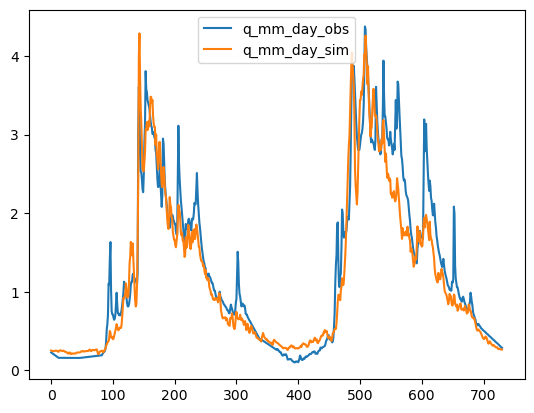

In [18]:
test_data.plot()

### Prepare data with no misses on discharge and level

In [ ]:
def xr_opener(file):
    ds = xr.open_dataset(file)
    if "index" in ds.coords:
        ds = ds.rename({"index": "date"})
    return ds


files = glob.glob(f"../geo_data/great_db/nc_concat/*.nc")
big_file = xr.concat([xr_opener(file) for file in files], dim="gauge_id")
for gauge in (
    big_file[["q_mm_day", "lvl_mbs"]].dropna(dim="gauge_id")["gauge_id"].values
):
    ds = big_file.sel(gauge_id=gauge)
    ds.to_netcdf(f"../geo_data/great_db/nc_all_q_h/{gauge}.nc")

### Prepare name lists for used variables and read geometry

In [4]:
era_input = ["prcp_e5l", "t_max_e5l", "t_min_e5l"]
# q_mm_day or lvl_mbs or lvl_sm
hydro_target = "lvl_sm"
q_h_relation = False

if (hydro_target == "lvl_mbs") | (hydro_target == "lvl_sm"):
    static_parameters = [
        "for_pc_sse",
        "crp_pc_sse",
        "inu_pc_ult",
        "ire_pc_sse",
        "lka_pc_use",
        "prm_pc_sse",
        "pst_pc_sse",
        "cly_pc_sav",
        "slt_pc_sav",
        "snd_pc_sav",
        "kar_pc_sse",
        "urb_pc_sse",
        "gwt_cm_sav",
        "lkv_mc_usu",
        "rev_mc_usu",
        "sgr_dk_sav",
        "slp_dg_sav",
        "ws_area",
        "ele_mt_sav",
        "height_bs",
    ]
    nc_variable = "nc_all_h"
    if q_h_relation:
        nc_variable = "nc_all_q_h"
else:
    static_parameters = [
        "for_pc_sse",
        "crp_pc_sse",
        "inu_pc_ult",
        "ire_pc_sse",
        "lka_pc_use",
        "prm_pc_sse",
        "pst_pc_sse",
        "cly_pc_sav",
        "slt_pc_sav",
        "snd_pc_sav",
        "kar_pc_sse",
        "urb_pc_sse",
        "gwt_cm_sav",
        "lkv_mc_usu",
        "rev_mc_usu",
        "sgr_dk_sav",
        "slp_dg_sav",
        "ws_area",
        "ele_mt_sav",
    ]
    nc_variable = "nc_all_q"

ws_file = gpd.read_file("../geo_data/great_db/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")

### Data preparation description

#### Store in **time_series** directory every necessary file for train procedure
It stores data about predictors (**prcp_e5l, t_max_e5l, t_min_e5l**) and predicats (**q_mm_day**)

Design of the model builded up on **two** steps:

**first**: create LSTM to predict future discharge (**q_mm_day**)

**second**: create LSTM to predict future level (**lvl_mbs**) with information about predicted (**q_mm_day**) and (**prcp_e5l, t_max_e5l, t_min_e5l**)
<br/><br/>

This model allows to inference with cmip meteo data

(**precipitation_{model}, daily_maximum_near_surface_air_temperature_{model}, daily_minimum_near_surface_air_temperature_{model}**)

and previously predicted (**q_mm_day**)

In [5]:
with open("./cmip_ranks.json") as json_file:
    cmip_models = json.load(json_file)
cmip_models = list(cmip_models.values())

meteo_inputs = dict()
for model in cmip_models:
    meteo_inputs[model] = [
        f"precipitation_{model}",
        f"daily_maximum_near_surface_air_temperature_{model}",
        f"daily_minimum_near_surface_air_temperature_{model}",
    ]
# time series directory
ts_dir = Path("../geo_data/time_series")

### NeuralHydrology train data
Relies on config file. **Main** attention should be payed to **data_dir** argument
This folder is the reference to place where all required data are stored

<br><br/>
Framework automaticcally seek for **time_series** folder which should contain data **for each gauge** in desired experiment
and has all available meteo data in **.nc** format

To inlude static parameters **data_dir** should also has **attributes** folder with **.csv** file for each used gauge as an index of this file



In [ ]:
# write files for train procedure
print(f"train data for {hydro_target} with {nc_variable} initial data")
train_rewriter(
    era_paths=glob.glob(f"../geo_data/great_db/{nc_variable}/*.nc"),
    ts_dir=ts_dir,
    hydro_target=hydro_target,
    area_index=ws_file.index,
    predictors=era_input,
)

### Config setup

Here we define files for **train**, **validation** and **test**

It's possible to use different gauges for certain steps of model learn procedure,

but in this example we'll use every possible gauge and split it **not in space**, but with **different time periods**

'**train_start_date**': '01/01/2009',

'**train_end_date**': '31/12/2016',

'**validation_start_date**': '01/01/2017',

'**validation_end_date**': '31/12/2018',

'**test_start_date**': '01/01/2019',

'**test_end_date**': '31/12/2020'


In [ ]:
# define variables require to perform hindcast
gauges = [file.split("/")[-1][:-3] for file in glob.glob(f"{ts_dir}/*.nc")]
random.shuffle(gauges)
gauge_size = len(gauges)

# with open('./every_basin.txt', 'w') as the_file:
#     for gauge_name in gauges:
#         the_file.write(f'{gauge_name}\n')

train_gauges = gauges[: int(len(gauges) * 0.8)]
with open("./basins_train.txt", "w") as the_file:
    for gauge_name in train_gauges:
        the_file.write(f"{gauge_name}\n")

val_gauges = gauges[
    int(gauge_size * 0.8): int(gauge_size * 0.8) + int(gauge_size * 0.1)
]
with open("./basins_val.txt", "w") as the_file:
    for gauge_name in val_gauges:
        the_file.write(f"{gauge_name}\n")

test_gauges = gauges[int(gauge_size * 0.8) + int(gauge_size * 0.1):]
with open("./basins_test.txt", "w") as the_file:
    for gauge_name in test_gauges:
        the_file.write(f"{gauge_name}\n")

cfg = Config(Path("./model_config.yml"))
# base model type [cudalstm, customlstm, ealstm, embcudalstm, mtslstm, gru, transformer]
# (has to match the if statement in modelzoo/__init__.py)
model_name = "cudalstm"
cfg.update_config(
    yml_path_or_dict={
        # define storage and experiment
        "experiment_name": f"{model_name}_{hydro_target}",
        "model": f"{model_name}",
        "run_dir": "./",
        "data_dir": "../geo_data/",
        # define inner parameters
        "static_attributes": static_parameters,
        "dynamic_inputs": era_input,
        # 'hindcast_inputs': era_input,
        # 'forecast_inputs': era_input,
        "target_variables": [hydro_target],
        # 'dynamics_embedding': {'type': 'fc', 'hiddens': [128, 64, 256],
        #                       'activation': 'tanh', 'dropout': 0.2},
        # 'statics_embedding': {'type': 'fc', 'hiddens': [128, 64, 256],
        #                      'activation': 'tanh', 'dropout': 0.2},
        # define files with gauge data
        "train_basin_file": "./every_basin.txt",
        "validate_n_random_basins": gauge_size,
        "validation_basin_file": "./every_basin.txt",
        "test_basin_file": "./every_basin.txt",
        # define time periods
        # 'seq_length': 14,
        # 'forecast_seq_length': 10,
        "train_start_date": "01/01/2009",
        "train_end_date": "31/12/2016",
        "validation_start_date": "01/01/2017",
        "validation_end_date": "31/12/2018",
        "test_start_date": "01/01/2019",
        "test_end_date": "31/12/2020",
    }
)
cfg.dump_config(
    folder=Path("./launch_configs"), filename=f"{model_name}_{hydro_target}.yml"
)

In [ ]:
if torch.cuda.is_available():
    start_run(config_file=Path(
        f"./launch_configs/{model_name}_{hydro_target}.yml"))

### Test setup

Main idea is to just replace meteo input from **era** with the **cmip's**

So the learned weights of **era** model will be used with **cmip's** data


We rewrite files in **time_series** directory 
with data for **desired** gauges and new **dynamic_inputs** from selected **cmip**

In [19]:
# get cmips
cmip_path = "../geo_data/cmip_concat_new/ssp_2_4_5/"
obs_pathes = glob.glob("../geo_data/great_db/nc_all_q_h/*.nc")
# get gauge id's
with open("./delete_me_test.txt", "r") as f:
    res = [line.strip() for line in f]
f.close()

# write files for test procedure
print(f"test data for {hydro_target} with {nc_variable} initial data")
test_rewriter(
    train_with_obs=obs_pathes,
    cmip_storage=cmip_path,
    test_index=res,
    predictors=meteo_inputs["ec_earth3_veg_lr"],
    era_names=era_input,
    ts_dir=ts_dir,
)

test data for lvl_sm with nc_all_h initial data


Update config that we get from **train** procedure

with new **dynamic_iputs** from selected **cmip** and and new **test_start_date** and **test_end_date**

In [20]:
cfg = Config(Path("./model_runs/cudalstm_lvl_sm_0809_073042/config.yml"))
# cfg.update_config(yml_path_or_dict = {'test_basin_file': '/workspaces/my_dissertation/neural_forecast/delete_me_test.txt',
#                                       'test_start_date': '01/01/2018',
#                                       'test_end_date': '31/12/2020',
#                                       'dynamic_inputs': meteo_inputs['ec_earth3_veg_lr']})
cfg.update_config(
    yml_path_or_dict={
        "test_basin_file": "/workspaces/my_dissertation/neural_forecast/delete_me_test.txt",
        "test_start_date": "01/01/2018",
        "test_end_date": "31/12/2025",
    }
)

Run **test** on selected gauge

In [21]:
tester = get_tester(cfg=cfg, run_dir=cfg.run_dir,
                    period="test", init_model=True)
pred_results = tester.evaluate(epoch=22, save_results=False)

# Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

# Evaluation: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


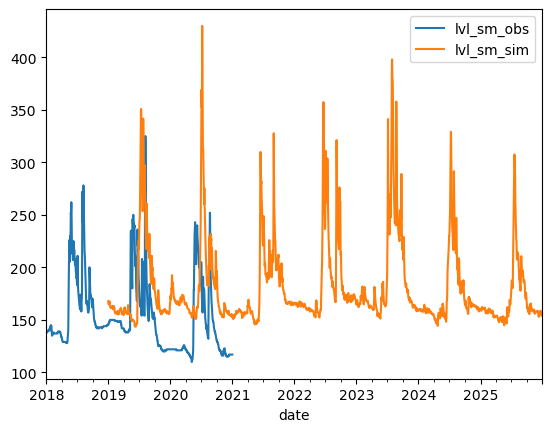

In [23]:
pred_results["1151"]["1D"]["xr"].to_dataframe().droplevel(1).plot()

### Run ready models to get result (different meteo input)

In [18]:
configs = list(Path("./model_runs/").glob("cudalstm_q_mm_day*/config.yml"))
configs_names = [str(i).split("/")[1].split("_no")[0] for i in configs]
best_epochs = [24, 24, 20, 26, 30]

meteo_inputs = [
    ["prcp_gpcp", "t_max_e5l", "t_min_e5l"],
    ["prcp_mswep", "t_max_e5l", "t_min_e5l"],
    ["prcp_e5", "t_max_e5", "t_min_e5"],
    ["prcp_e5l", "t_max_e5l", "t_min_e5l"],
    ["prcp_mswep", "t_max_e5", "t_min_e5"],
]

In [4]:
# q_mm_day or lvl_sm
hydro_target = "q_mm_day"
static_parameters = [
    "for_pc_sse",
    "crp_pc_sse",
    "inu_pc_ult",
    "ire_pc_sse",
    "lka_pc_use",
    "prm_pc_sse",
    "pst_pc_sse",
    "cly_pc_sav",
    "slt_pc_sav",
    "snd_pc_sav",
    "kar_pc_sse",
    "urb_pc_sse",
    "gwt_cm_sav",
    "lkv_mc_usu",
    "rev_mc_usu",
    "ws_area",
    "ele_mt_sav",
]
nc_variable = "nc_all_q"

ws_file = read_ws("../geo_data/geometry/russia_ws.gpkg")

# time series directory
ts_dir = Path("../geo_data/time_series")
ts_dir.mkdir(exist_ok=True, parents=True)

In [6]:
# write files for train procedure
print(f"train data for {hydro_target} with {nc_variable} initial data")
train_rewriter(
    era_paths=glob.glob(f"../geo_data/ws_related_meteo/{nc_variable}/*.nc"),
    ts_dir=ts_dir,
    hydro_target=hydro_target,
    area_index=ws_file.index,
    predictors=[*meteo_inputs[0]],
    possible_nans=1,
)

train data for q_mm_day with nc_all_q initial data


In [7]:
cfg = Config(Path(configs[0]))
eval_run(run_dir=cfg.run_dir, period="test", epoch=24)

# Evaluation:   0%|          | 0/1112 [00:00<?, ?it/s]

# Evaluation: 100%|██████████| 1112/1112 [01:23<00:00, 13.26it/s]


In [14]:
f = pd.read_csv(metric_file)
f = f.rename(columns={"basin": "gauge_id"})
f["gauge_id"] = f["gauge_id"].astype(str)
f = f.set_index("gauge_id")
f

,NSE,RMSE,KGE
gauge_id,,,
10006,0.849720,0.185374,0.799055
10015,0.734694,0.151716,0.850197
10021,0.935766,0.104635,0.930620
10042,0.779476,0.444436,0.881910
10044,0.763147,0.518024,0.858677
...,...,...,...
9546,0.514087,1.291043,0.438084
9547,0.286863,0.193869,0.483158
9560,0.836001,0.482180,0.679645


In [17]:
configs_names

'l'

In [23]:
for config_name, metric_file in zip(
    configs_names,
    list(Path("./model_runs/").glob("cudalstm_q_mm_day*/test/*/test_metrics.csv")),
):
    f = pd.read_csv(metric_file)
    f = f.rename(columns={"basin": "gauge_id"})
    f["gauge_id"] = f["gauge_id"].astype(str)
    f = f.set_index("gauge_id")
    nse_med = f["NSE"].median()
    print(f"for {config_name} NSE = {nse_med:.3f}")
    f.to_csv(f"../conclusions/tables/{config_name}_res.csv")

for cudalstm_q_mm_day_gpcp NSE = 0.582
for cudalstm_q_mm_day_mswep NSE = 0.641
for cudalstm_q_mm_day_era5 NSE = 0.631
for cudalstm_q_mm_day_era5l NSE = 0.626
for cudalstm_q_mm_day_mswep_era5 NSE = 0.636


In [1]:
import gc
import glob
import random
from pathlib import Path

import geopandas as gpd
import torch
from neuralhydrology.nh_run import start_run
from neuralhydrology.utils.config import Config
from scripts.file_manipulator import train_rewriter

# era_input = ["prcp_e5l", "t_max_e5l", "t_min_e5l"]
era_input = ["prcp_mswep", "t_max_e5l", "t_min_e5l"]
# q_mm_day or lvl_sm
hydro_target = "q_mm_day"
q_h_relation = False

if hydro_target == "lvl_sm":
    static_parameters = [
        "for_pc_sse",
        "crp_pc_sse",
        "inu_pc_ult",
        "ire_pc_sse",
        "lka_pc_use",
        "prm_pc_sse",
        "pst_pc_sse",
        "cly_pc_sav",
        "slt_pc_sav",
        "snd_pc_sav",
        "kar_pc_sse",
        "urb_pc_sse",
        "gwt_cm_sav",
        "lkv_mc_usu",
        "rev_mc_usu",
        "ws_area",
        "ele_mt_sav",
        "height_bs",
    ]
    nc_variable = "nc_all_h"
    if q_h_relation:
        nc_variable = "nc_all_q_h"
else:
    static_parameters = [
        "for_pc_sse",
        "crp_pc_sse",
        "inu_pc_ult",
        "ire_pc_sse",
        "lka_pc_use",
        "prm_pc_sse",
        "pst_pc_sse",
        "cly_pc_sav",
        "slt_pc_sav",
        "snd_pc_sav",
        "kar_pc_sse",
        "urb_pc_sse",
        "gwt_cm_sav",
        "lkv_mc_usu",
        "rev_mc_usu",
        "ws_area",
        "ele_mt_sav",
    ]
    nc_variable = "nc_all_q"

ws_file = gpd.read_file(filename="../geo_data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")

# time series directory
ts_dir = Path("../geo_data/time_series")
ts_dir.mkdir(exist_ok=True, parents=True)
# write files for train procedure

In [ ]:
for gauge_id in ws_file.index:
    print(f"train data for {hydro_target} with {nc_variable} initial data")
    train_rewriter(
        era_paths=glob.glob(
            f"../geo_data/ws_related_meteo/{nc_variable}/*.nc"),
        ts_dir=ts_dir,
        hydro_target=hydro_target,
        area_index=[gauge_id],
        predictors=[*era_input],
        possible_nans=1,
    )

In [5]:
gauges = [file.split("/")[-1][:-3] for file in glob.glob(f"{ts_dir}/*.nc")]

random.shuffle(gauges)

In [10]:
import pandas as pd

test_f = pd.read_csv("../geo_data/attributes/static_with_height.csv")
test_f["gauge_id"] = test_f["gauge_id"].astype(str)
test_f = test_f.set_index("gauge_id")

In [14]:
isinstance(test_f.loc["9002"], pd.Series)

True

In [60]:
initial_df

,for_pc_sse,crp_pc_sse,inu_pc_ult,ire_pc_sse,lka_pc_use,prm_pc_sse,pst_pc_sse,cly_pc_sav,slt_pc_sav,snd_pc_sav,kar_pc_sse,urb_pc_sse,gwt_cm_sav,lkv_mc_usu,rev_mc_usu,sgr_dk_sav,slp_dg_sav,ws_area,ele_mt_sav,height_bs
9002,71.405729,1.119471,0.884372,0.0,0.712373,54.037087,1.342302,10.445704,40.55478,49.022949,11.302106,0.038855,290.149989,436.800398,0.0,196.390061,11.175569,115263.989,1532.822907,615.5


In [66]:
initial_df = test_f.iloc[0, :].to_frame().T

In [80]:
365 * 256

93440

In [73]:
initial_df.T

,9002
for_pc_sse,71.405729
crp_pc_sse,1.119471
inu_pc_ult,0.884372
ire_pc_sse,0.000000
lka_pc_use,0.712373
prm_pc_sse,54.037087
pst_pc_sse,1.342302
cly_pc_sav,10.445704
slt_pc_sav,40.554780
snd_pc_sav,49.022949
